# Part 1: Data Collection

In [1]:
import pandas as pd
import os
# Definisci il percorso al desktop
desktop = os.path.join(os.path.expanduser("~"), "OneDrive\Desktop")

# Definisci il percorso completo al file
file_path = os.path.join(desktop, "airports.dat")

# Carica il file con pandas specificando il separatore (ad esempio spazi o tabulazioni)
df1 = pd.read_csv(file_path, delimiter=',', header=None)  # Modifica ' ' in base al separatore (es: '\t' per tabulazioni)

# Visualizza le prime righe del dataset
print(df1.head())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/leo/OneDrive\\Desktop/airports.dat'

In [2]:
print(df1.columns)
print(df1[4])

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')
0       GKA
1       MAG
2       HGU
3       LAE
4       POM
       ... 
7693     \N
7694     \N
7695     \N
7696    CPO
7697     \N
Name: 4, Length: 7698, dtype: object


In [3]:
import pandas as pd
import os

# Definisci il percorso al desktop
desktop = os.path.join(os.path.expanduser("~"), "OneDrive\Desktop")

# Definisci il percorso completo al file
file_path = os.path.join(desktop, "routes.dat")

# Carica il file con pandas specificando il separatore (ad esempio spazi o tabulazioni)
df2 = pd.read_csv(file_path, delimiter=',', header=None)  # Modifica ' ' in base al separatore (es: '\t' per tabulazioni)

# Visualizza le prime righe del dataset
print(df2.head())

    0    1    2     3    4     5    6  7    8
0  2B  410  AER  2965  KZN  2990  NaN  0  CR2
1  2B  410  ASF  2966  KZN  2990  NaN  0  CR2
2  2B  410  ASF  2966  MRV  2962  NaN  0  CR2
3  2B  410  CEK  2968  KZN  2990  NaN  0  CR2
4  2B  410  CEK  2968  OVB  4078  NaN  0  CR2


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Estrai i nodi dal primo dataset (valori distinti di una determinata colonna)
nodi = df1[4].unique()

# Crea il grafo
G = nx.Graph()

# Aggiungi i nodi al grafo
G.add_nodes_from(nodi)

# Per ogni riga del secondo dataset, se una coppia di nodi appare nella stessa riga, crea un arco tra di loro
for _, row in df2.iterrows():
    # Estrai i valori della riga come una lista di nodi candidati
    candidati = row.values
    
    # Crea archi tra ogni coppia di nodi presenti contemporaneamente nella stessa riga
    for i in range(len(candidati)):
        for j in range(i + 1, len(candidati)):
            if candidati[i] in nodi and candidati[j] in nodi:
                if G.has_edge(candidati[i], candidati[j]):
                    current_weight = G[candidati[i]][candidati[j]]['weight']
                    G[candidati[i]][candidati[j]]['weight'] = current_weight + 1
                else:
                    G.add_edge(candidati[i], candidati[j], weight=1)

In [5]:
G.remove_node('\\N')

In [6]:
G.number_of_nodes()

6072

In [7]:
G.number_of_edges()

19730

In [8]:
nx.write_edgelist(G,'SNAerei.csv')

In [9]:
sum(dict(G.degree()).values())/float(len(G))

6.498682476943347

# Part 2: Network Analysis

## 2.1 Degree Distribution

In [10]:
import os
os.system('pip install powerlaw')

0

In [11]:
import powerlaw

In [12]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import powerlaw

def plot_dist(G):
    # Convert NetworkX graph to SciPy sparse adjacency matrix
    M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array

    # Compute degree of nodes
    indegrees = M.sum(axis=0)  # Sum across rows to get degrees
    degree = np.bincount(indegrees.astype(int))  # Compute degree distribution
    
    # Fit the power-law distribution
    fit = powerlaw.Fit(np.array(degree) + 1, fit_method='KS')
    
    # Plot the degree distribution
    fig = plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)), degree, 'b.')
    plt.loglog()
    plt.xlim((min(degree[degree > 0]), max(degree)))  # Avoid log(0) issues
    plt.xlabel('Degree')
    plt.ylabel('P(k)')

    # Plot the CDF
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel("Degree")
    plt.ylabel('CDF')

    # Plot the CCDF
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.ylabel('CCDF')
    plt.xlabel('Degree')
    plt.tight_layout()
    plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_22472\3538649401.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array


Calculating best minimal value for power law fit


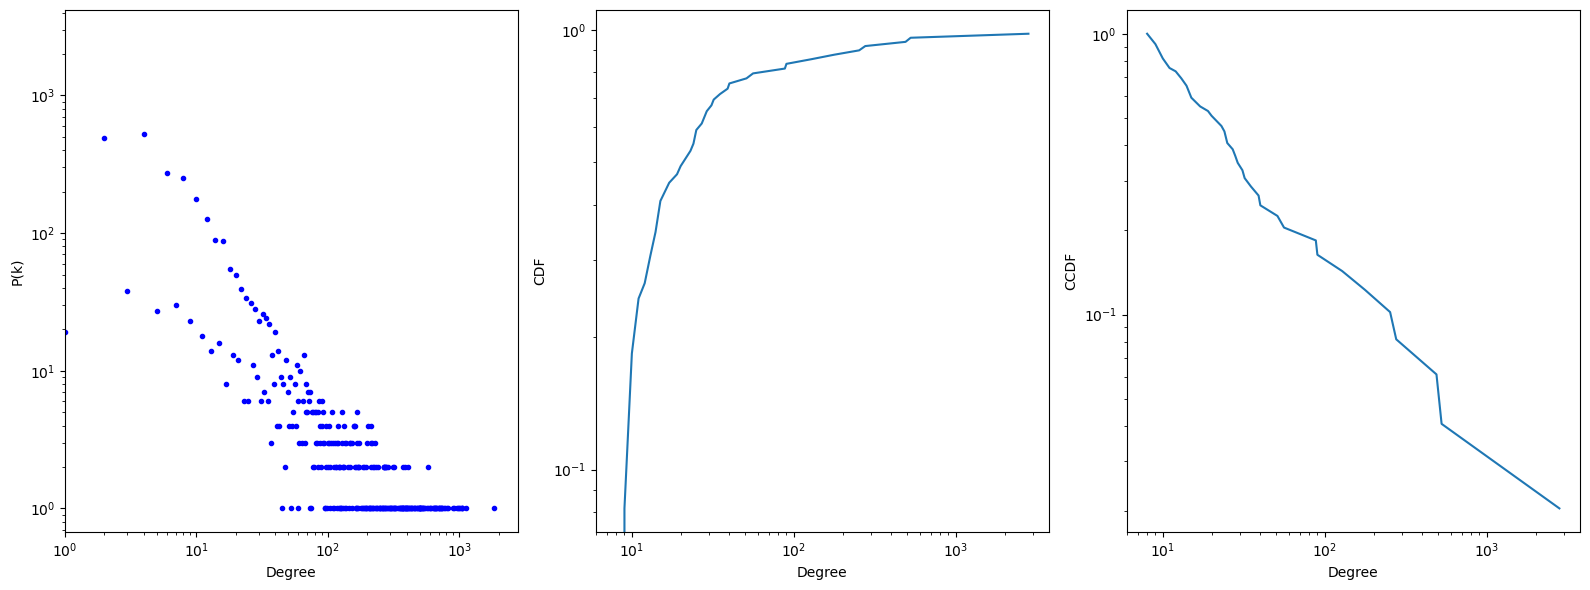

In [13]:
plot_dist(G)

## 2.2 Connected components analysis

In [14]:
nx.number_connected_components(G)

2809

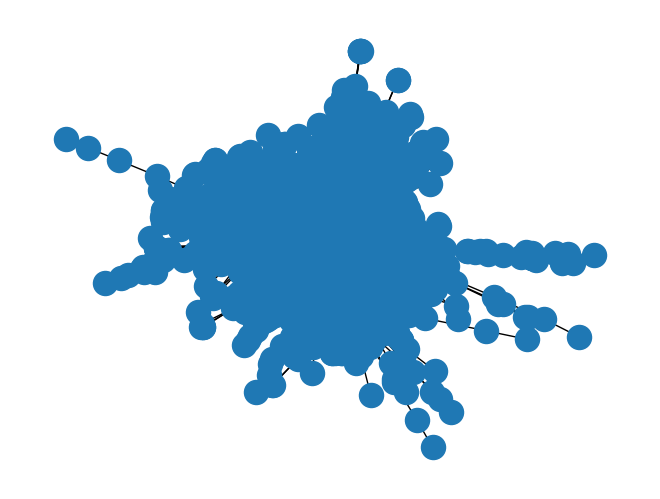

In [15]:
comps = list(nx.connected_components(G)) # get a list of connected components (for decreasing size)
comp_1 = nx.subgraph(G, comps[0]) # build a subgraph on the second component
nx.draw(comp_1)

In [16]:
comp_1.number_of_nodes()

3259

In [17]:
comp_1.number_of_edges()

19724

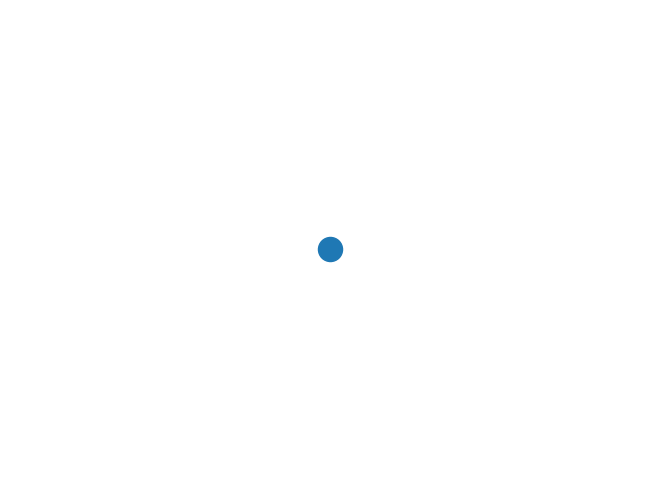

In [18]:
comps = list(nx.connected_components(G)) # get a list of connected components (for decreasing size)
comp_2 = nx.subgraph(G, comps[1]) # build a subgraph on the second component
nx.draw(comp_2)

In [19]:
comp_2.number_of_nodes()

1

In [20]:
comp_2.number_of_edges()

0

## 2.3 Path Analysis

In [21]:
# Distribuzione delle lunghezze dei percorsi più brevi
path_lengths = dict(nx.shortest_path_length(G))
all_lengths = [dist for lengths in path_lengths.values() for dist in lengths.values()]
print(f"Lunghezza media dei percorsi: {sum(all_lengths) / len(all_lengths):.2f}")
print(f"Lunghezza massima dei percorsi: {max(all_lengths)}")

Lunghezza media dei percorsi: 3.79
Lunghezza massima dei percorsi: 12


In [23]:
# Eccentricità e diametro del grafo
eccentricity = nx.eccentricity(comp_1)
print(f"Eccentricità del grafo: {eccentricity}")
diameter = nx.diameter(comp_1)
print(f"Diametro del grafo: {diameter}")
radius = nx.radius(comp_1)
print(f"Raggio del grafo: {radius}")

Eccentricità del grafo: {'GKA': 9, 'MAG': 9, 'HGU': 9, 'LAE': 9, 'POM': 8, 'WWK': 9, 'UAK': 9, 'GOH': 8, 'SFJ': 8, 'THU': 12, 'AEY': 10, 'EGS': 10, 'IFJ': 10, 'KEF': 7, 'RKV': 9, 'YAM': 7, 'YAY': 8, 'YBC': 8, 'YBG': 8, 'YBK': 9, 'YBL': 8, 'YBR': 8, 'YCB': 9, 'YCD': 8, 'YCG': 8, 'YCL': 8, 'YCO': 9, 'YCY': 9, 'YZS': 9, 'YDF': 7, 'YDQ': 8, 'YEG': 7, 'YEK': 9, 'YEV': 9, 'YFB': 8, 'YFC': 7, 'YFO': 8, 'YFS': 9, 'YGK': 7, 'YGL': 8, 'YGP': 8, 'YGR': 8, 'YHD': 8, 'YHI': 9, 'YHK': 9, 'YHM': 8, 'YHU': 8, 'YHY': 8, 'YHZ': 7, 'YIO': 10, 'YJT': 8, 'YKA': 8, 'YKF': 8, 'YKL': 8, 'YLL': 8, 'YLW': 7, 'YMM': 7, 'YMO': 8, 'YNA': 8, 'YOJ': 8, 'YOW': 7, 'YPL': 8, 'YPN': 9, 'YPR': 8, 'YPY': 8, 'YQB': 7, 'YQF': 8, 'YQG': 7, 'YQK': 8, 'YQL': 8, 'YQM': 7, 'YQQ': 8, 'YQR': 7, 'YQT': 7, 'YQU': 8, 'YQX': 8, 'YQY': 7, 'YQZ': 8, 'YRB': 9, 'YRT': 8, 'YSB': 7, 'YSJ': 7, 'YSM': 8, 'YSY': 9, 'YTE': 9, 'YTH': 8, 'YTS': 7, 'YTZ': 7, 'YUB': 9, 'YUL': 7, 'YUT': 9, 'YUX': 9, 'YUY': 8, 'YVM': 10, 'YVO': 8, 'YVP': 8, 'YVQ': 9,

Diametro del grafo: 12
Raggio del grafo: 6


In [24]:
# Connessione tra componenti
if not nx.is_connected(G):
    print("Il grafo non è connesso.")
    components = list(nx.connected_components(G))
    print(f"Numero di componenti connesse: {len(components)}")
    print(f"Dimensione di ogni componente: {[len(c) for c in components]}")
else:
    print("Il grafo è connesso.")

Il grafo non è connesso.
Numero di componenti connesse: 2809
Dimensione di ogni componente: [3259, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

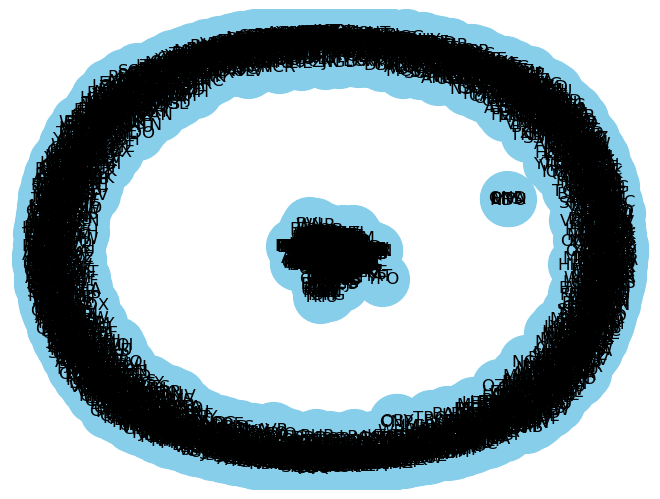

In [25]:
# Visualizzazione del grafo
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500)
plt.show()

## 2.4 Clustering Coeffient Analysis

In [26]:
nx.average_clustering(G) # compute the global clustering coefficient

0.2870804468080633

In [27]:
import networkx as nx

# Calcolo del clustering coefficient per ogni nodo
local_clustering = nx.clustering(G)
print("Clustering coefficient locale per ogni nodo:")
for node, coeff in local_clustering.items():
    print(f"Nodo {node}: {coeff:.3f}")


Clustering coefficient locale per ogni nodo:
Nodo GKA: 1.000
Nodo MAG: 0.571
Nodo HGU: 0.333
Nodo LAE: 0.389
Nodo POM: 0.117
Nodo WWK: 0.833
Nodo UAK: 0.300
Nodo GOH: 0.179
Nodo SFJ: 0.286
Nodo THU: 0.000
Nodo AEY: 0.000
Nodo EGS: 0.000
Nodo HFN: 0.000
Nodo HZK: 0.000
Nodo IFJ: 0.000
Nodo KEF: 0.487
Nodo PFJ: 0.000
Nodo RKV: 0.000
Nodo SIJ: 0.000
Nodo VEY: 0.000
Nodo YAM: 0.833
Nodo YAY: 0.833
Nodo YAZ: 0.000
Nodo YBB: 0.000
Nodo YBC: 1.000
Nodo YBG: 0.800
Nodo YBK: 0.600
Nodo YBL: 1.000
Nodo YBR: 0.000
Nodo YCB: 0.667
Nodo YCD: 1.000
Nodo YCG: 1.000
Nodo YCH: 0.000
Nodo YCL: 0.667
Nodo YCO: 0.333
Nodo YCT: 0.000
Nodo YCW: 0.000
Nodo YCY: 0.000
Nodo YZS: 0.400
Nodo YDA: 0.000
Nodo YDB: 0.000
Nodo YDF: 0.667
Nodo YDL: 0.000
Nodo YDN: 0.000
Nodo YDQ: 0.000
Nodo YEG: 0.319
Nodo YEK: 0.833
Nodo YEN: 0.000
Nodo YET: 0.000
Nodo YEU: 0.000
Nodo YEV: 0.321
Nodo YFB: 0.055
Nodo YFC: 1.000
Nodo YFE: 0.000
Nodo YFO: 1.000
Nodo YFR: 0.000
Nodo YFS: 1.000
Nodo YGK: 0.000
Nodo YGL: 0.333
Nodo YGP: 1

## 2.5 Density Analysis

In [28]:
nx.diameter(G.subgraph(comps[0])) # we compute the diameter on the giant component

12

In [29]:
nx.density(G)

0.0010704467924466062

## 2.6 Centrality Analysis

In [30]:
degrees = dict(comp_1.degree()) # compute the degree of a set of nodes (if specified).

In [31]:
ranks = [(k, v) for k, v in sorted(degrees.items(), key=lambda item: -item[1])]
ranks[0:5]

[('AMS', 248), ('FRA', 244), ('ATR', 242), ('CDG', 242), ('IST', 235)]

In [32]:
import matplotlib.colors as mcolors
%matplotlib inline 
pos = nx.spring_layout(G)
def draw_net(G, pos, measures, measure_name):
    
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

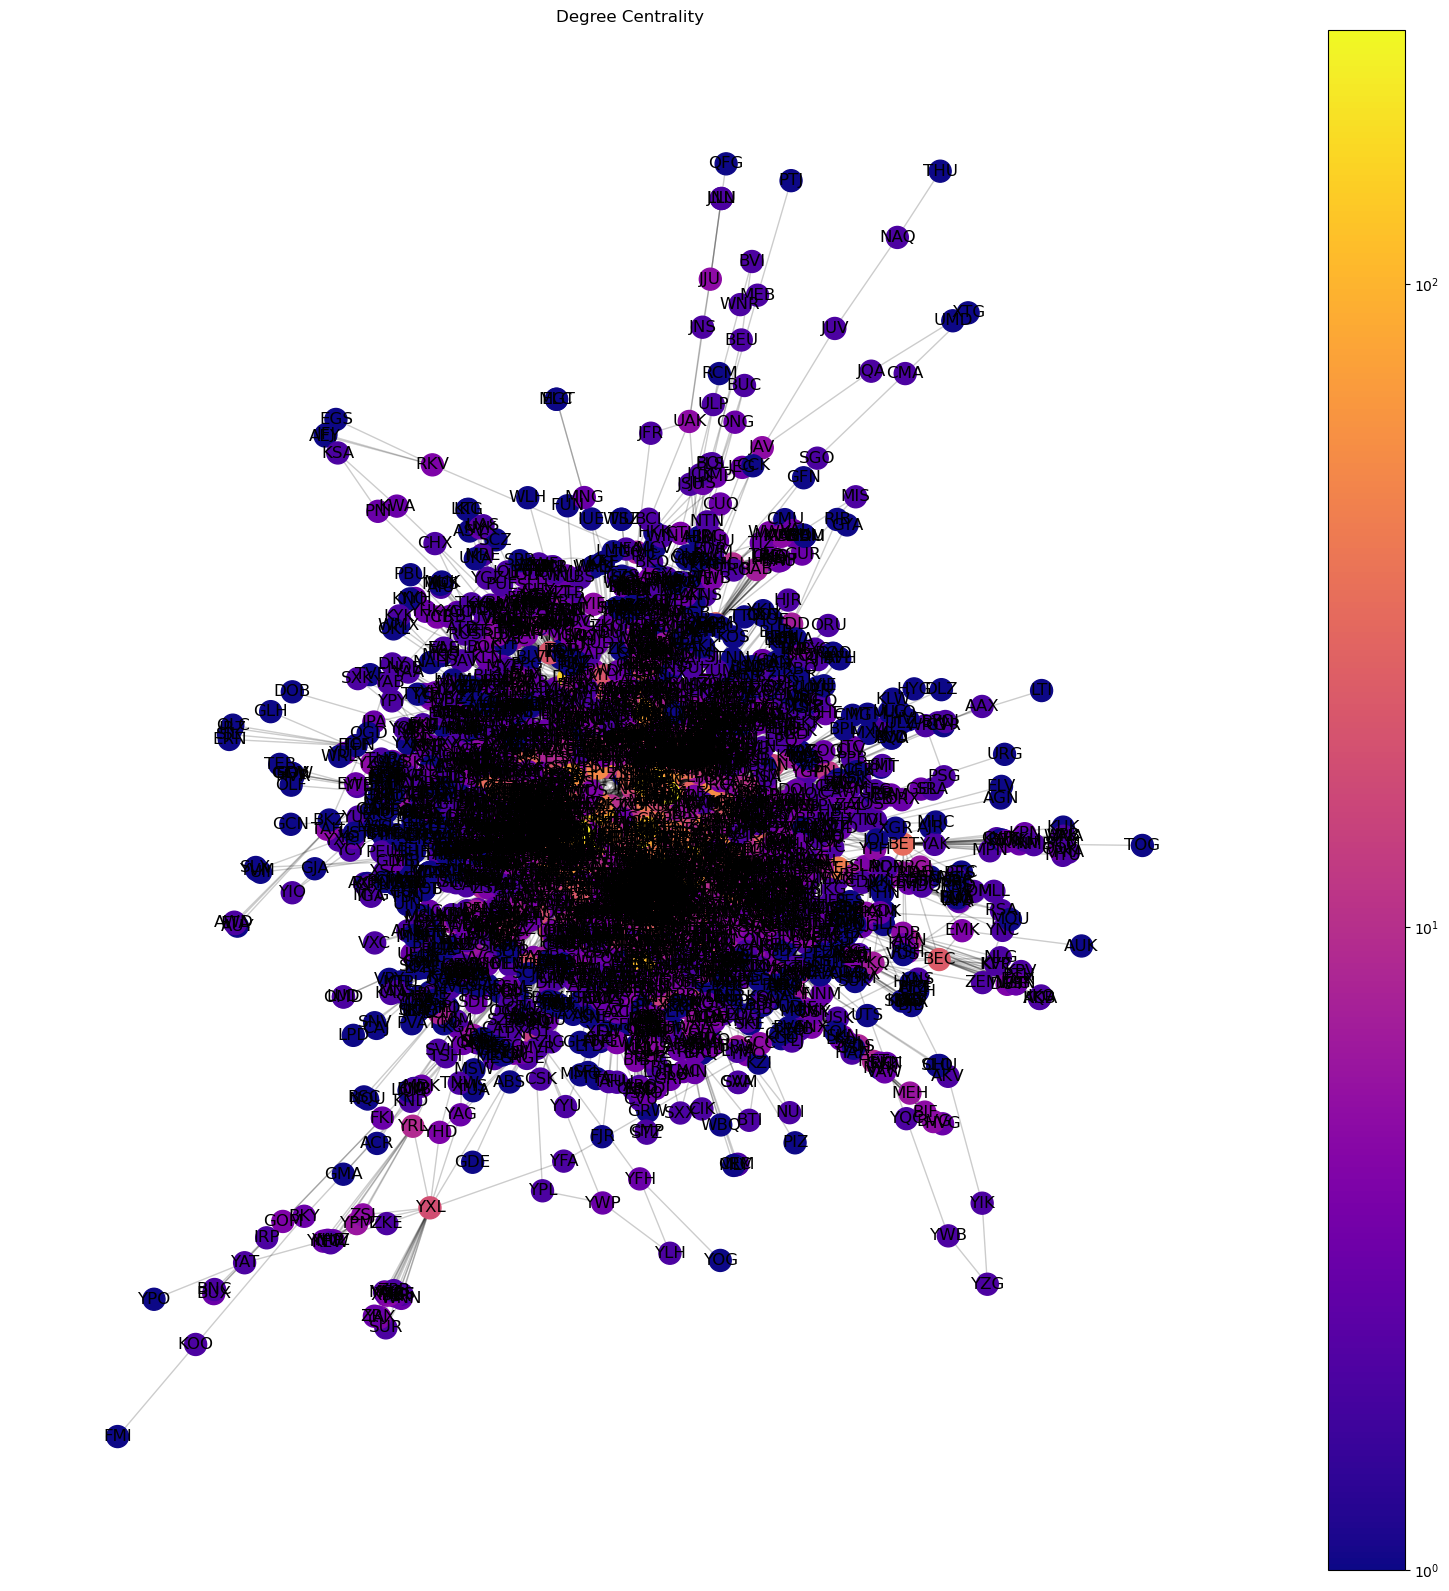

In [33]:
draw_net(comp_1, pos, degrees, 'Degree Centrality')

### Closeness Centrality Measure

In [34]:
closeness = nx.closeness_centrality(comp_1) # compute the closeness centrality of all nodes

In [35]:
ranks = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: -item[1])]
ranks[0:5]

[('CDG', 0.42610515302118757),
 ('FRA', 0.4206041828040279),
 ('LHR', 0.4156672620566471),
 ('AMS', 0.41198786039453716),
 ('DXB', 0.409811320754717)]

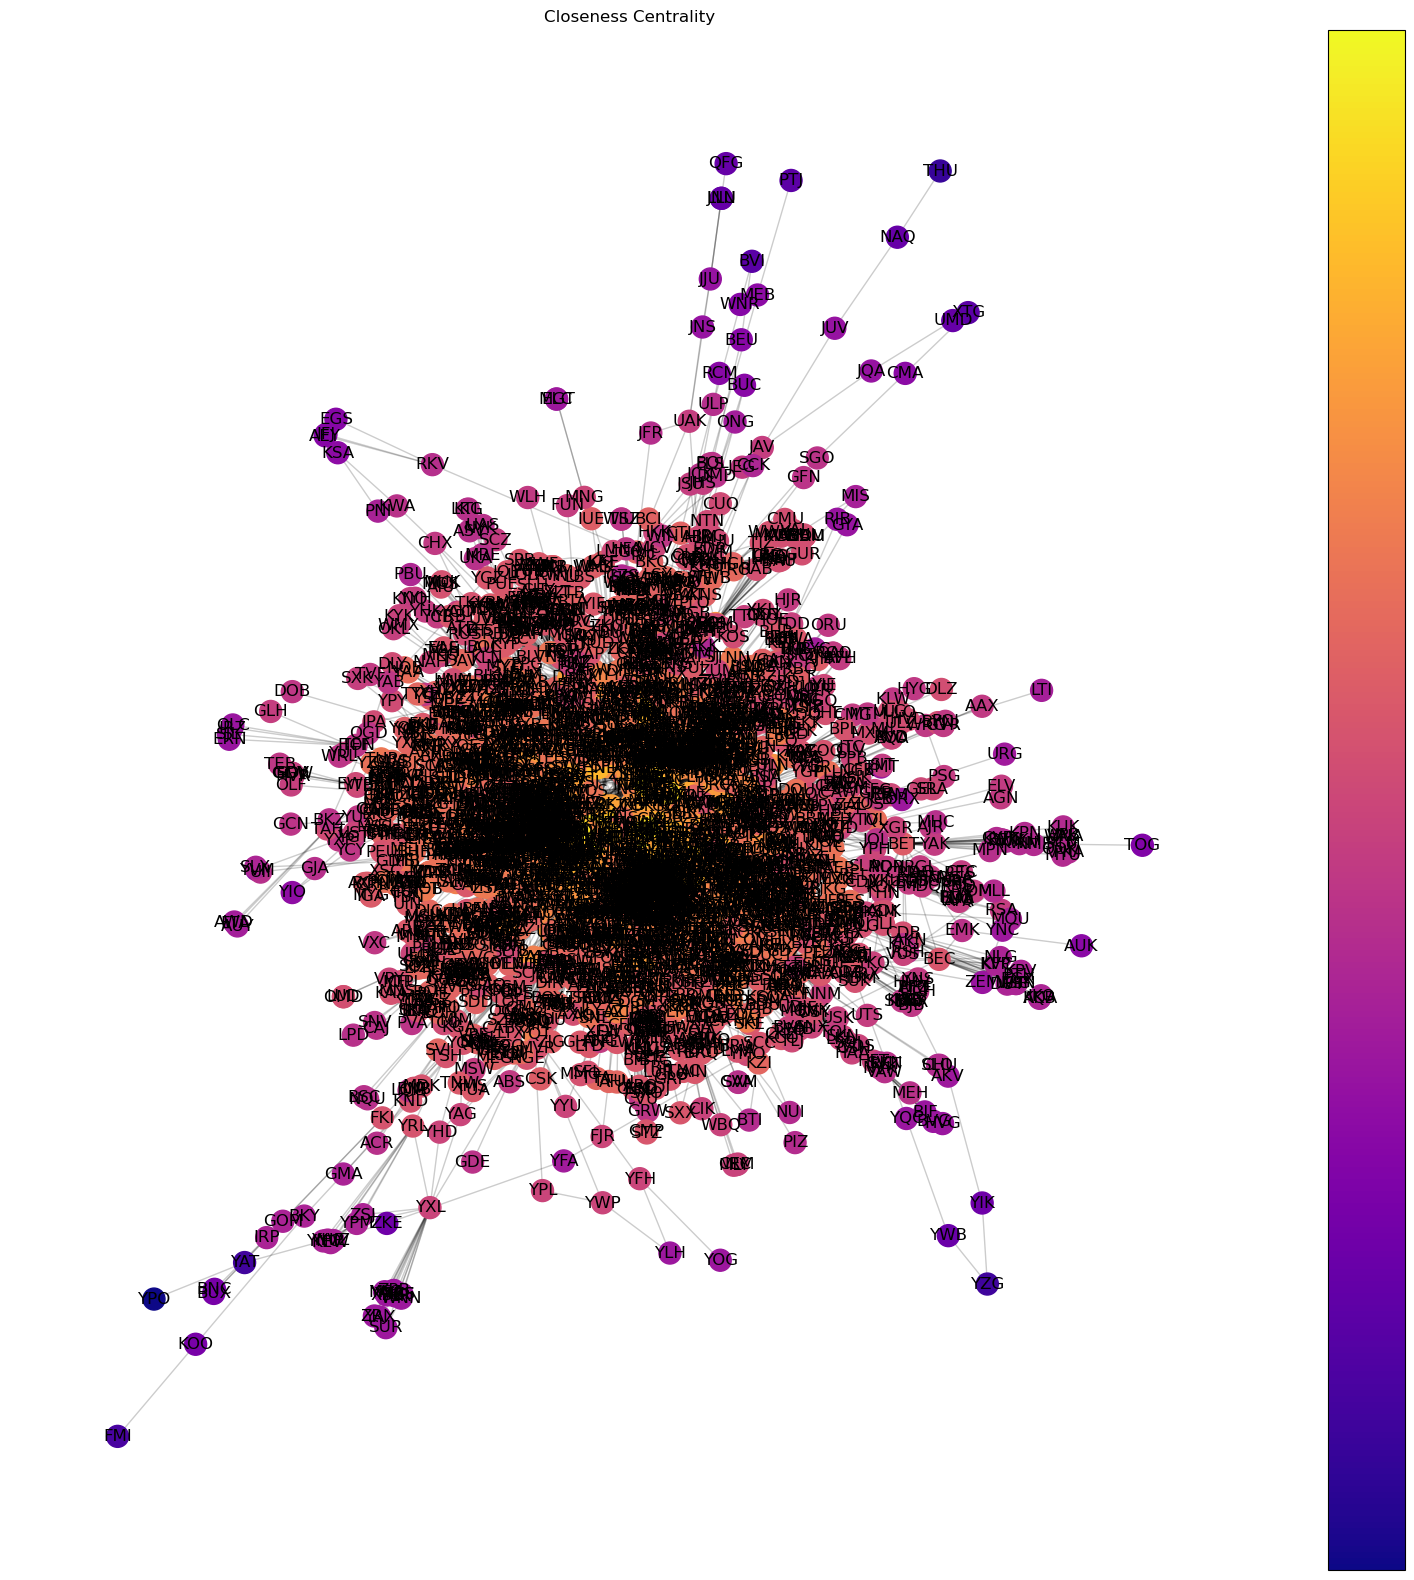

In [36]:
draw_net(comp_1, pos, closeness, 'Closeness Centrality')

### Betweenness Centrality

In [37]:
betweenness = nx.betweenness_centrality(comp_1) # compute the betweenness centraliry of all nodes

In [38]:
ranks = [(k, v) for k, v in sorted(betweenness.items(), key=lambda item: -item[1])]
ranks[0:5]

[('ATR', 0.08196620803863261),
 ('CDG', 0.060574248588514644),
 ('DHT', 0.057525074011806406),
 ('DXB', 0.046431714120472437),
 ('PEK', 0.04587154331983594)]

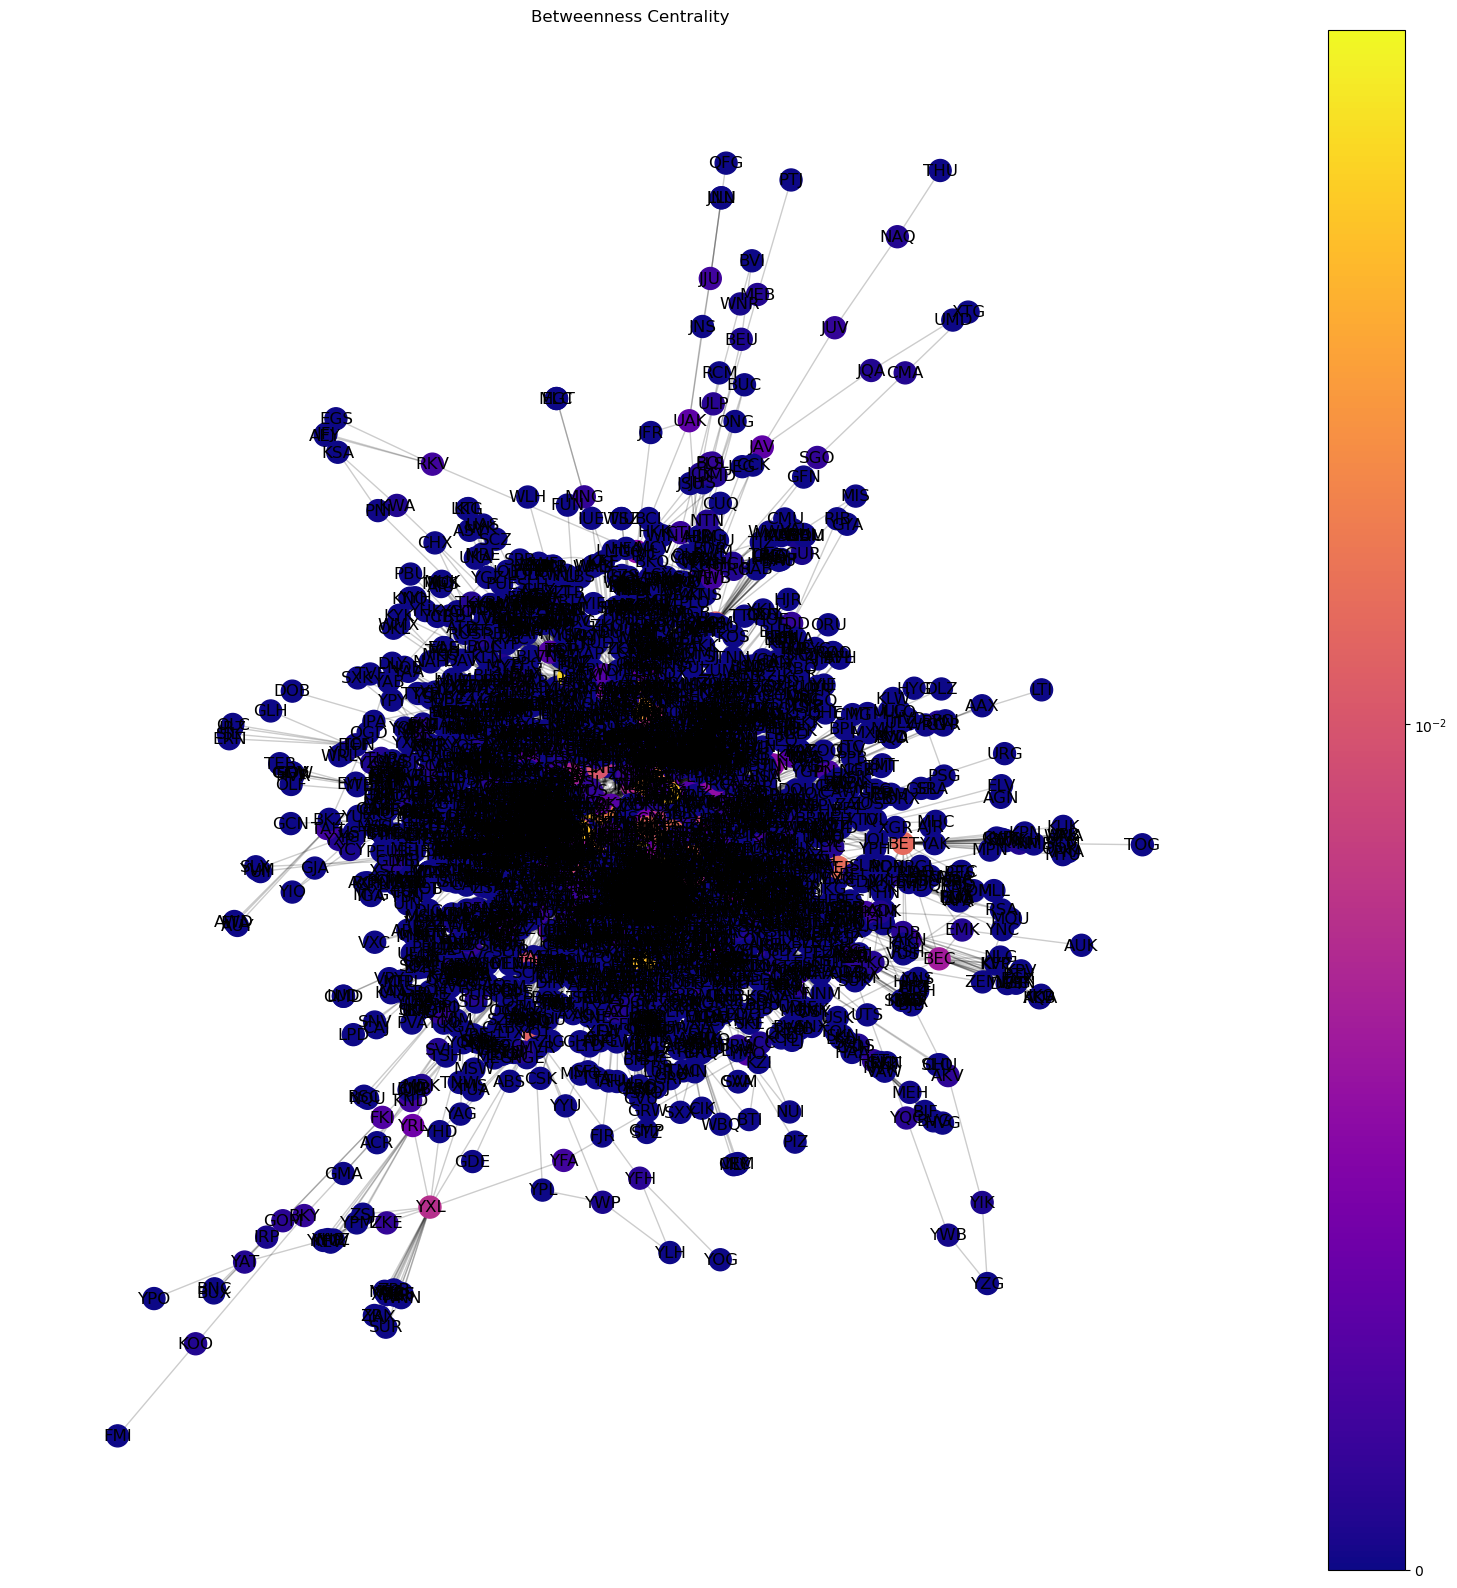

In [39]:
draw_net(comp_1, pos, betweenness, 'Betweenness Centrality')

### Harmonic Centrality

In [40]:
harmonic = nx.harmonic_centrality(comp_1)

In [41]:
ranks = [(k, v) for k, v in sorted(harmonic.items(), key=lambda item: -item[1])]
ranks[0:5]

[('CDG', 1539.8095238094902),
 ('FRA', 1524.8261904761596),
 ('AMS', 1501.3095238094922),
 ('LHR', 1485.909523809495),
 ('DXB', 1473.9190476190195)]

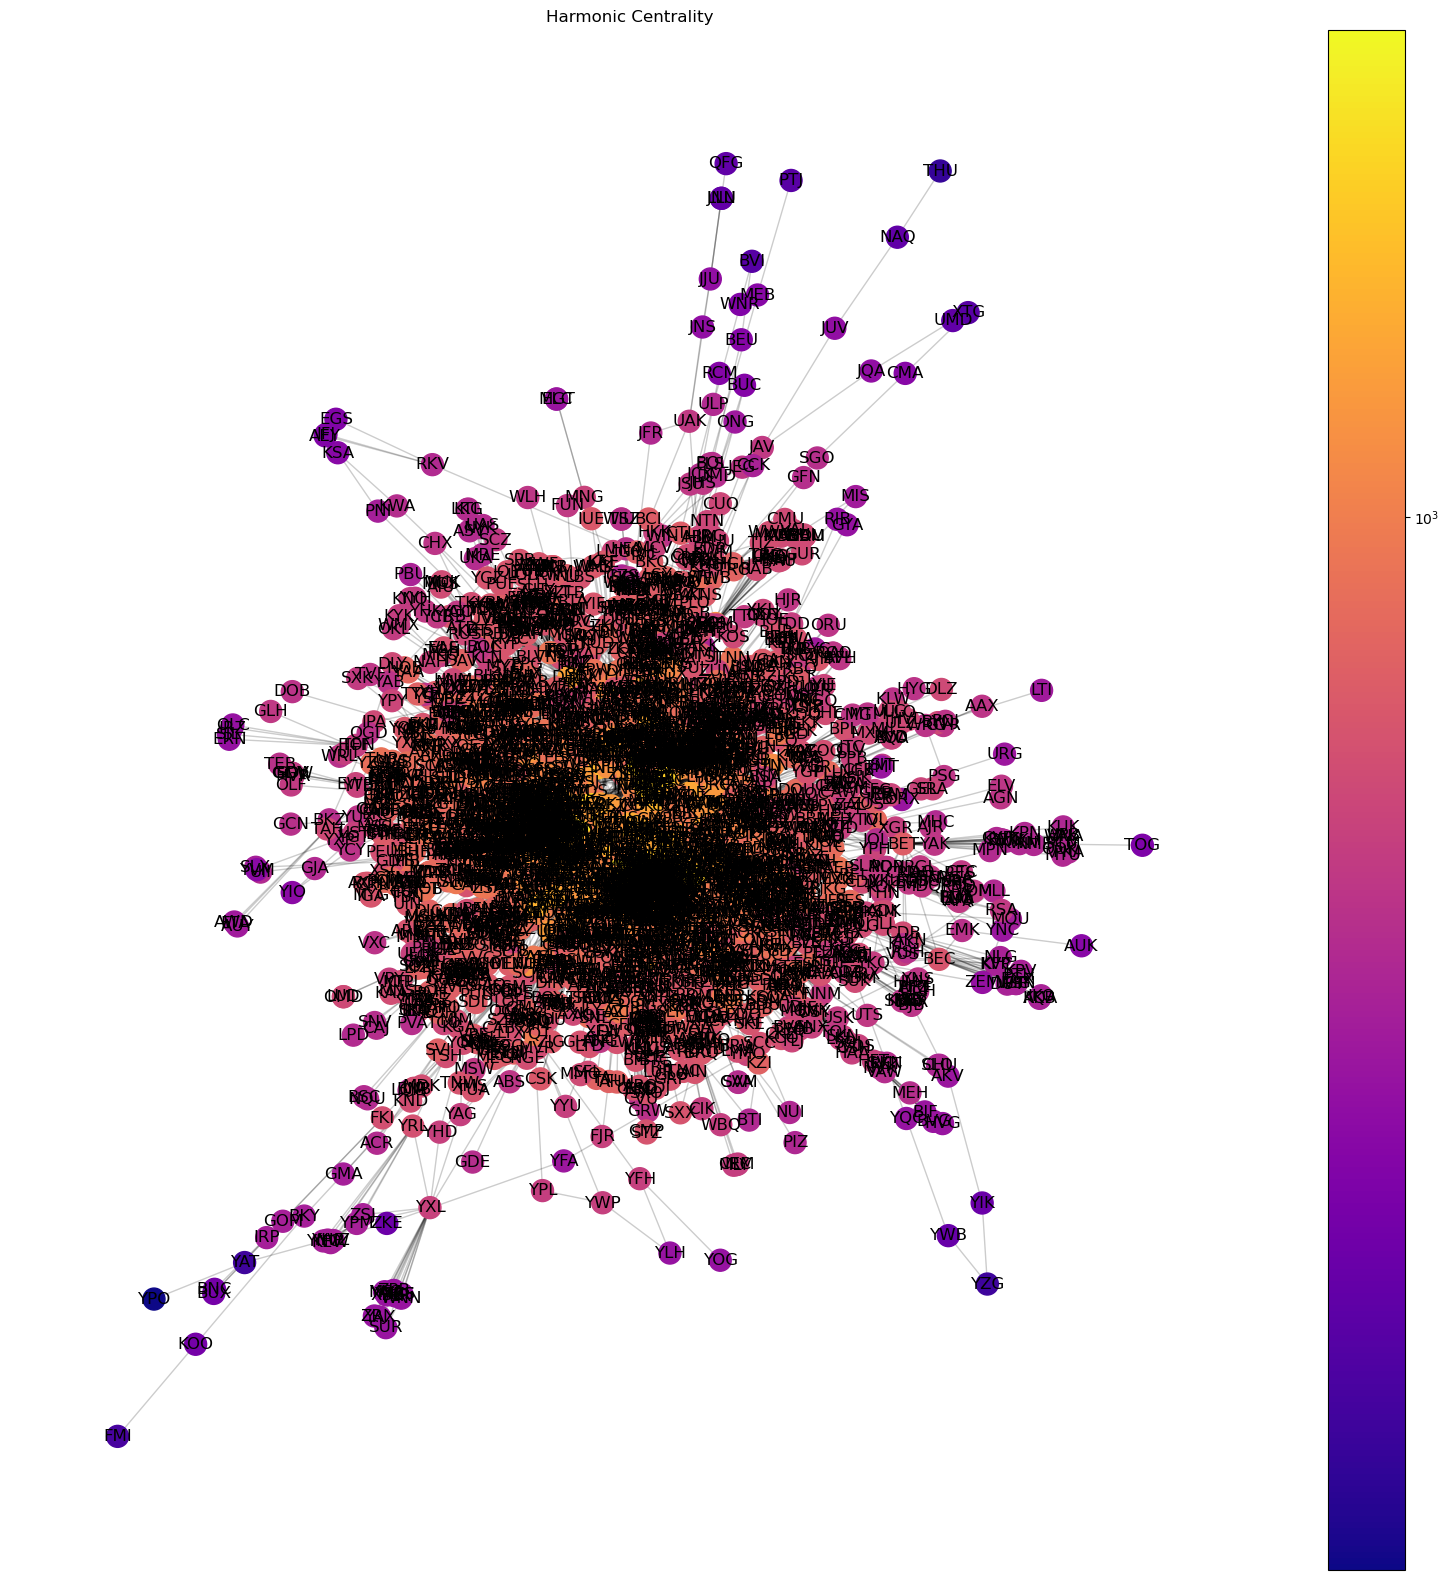

In [42]:
draw_net(comp_1, pos, harmonic, 'Harmonic Centrality')

### Pagerank Centrality

In [43]:
pagerank = nx.pagerank(comp_1)

In [44]:
ranks = [(k, v) for k, v in sorted(pagerank.items(), key=lambda item: -item[1])]
ranks[0:5]

[('ATL', 0.009394787062567089),
 ('ATR', 0.009094720139031067),
 ('DHT', 0.008217563374104443),
 ('CNC', 0.00638357218910697),
 ('ORD', 0.006008023104644776)]

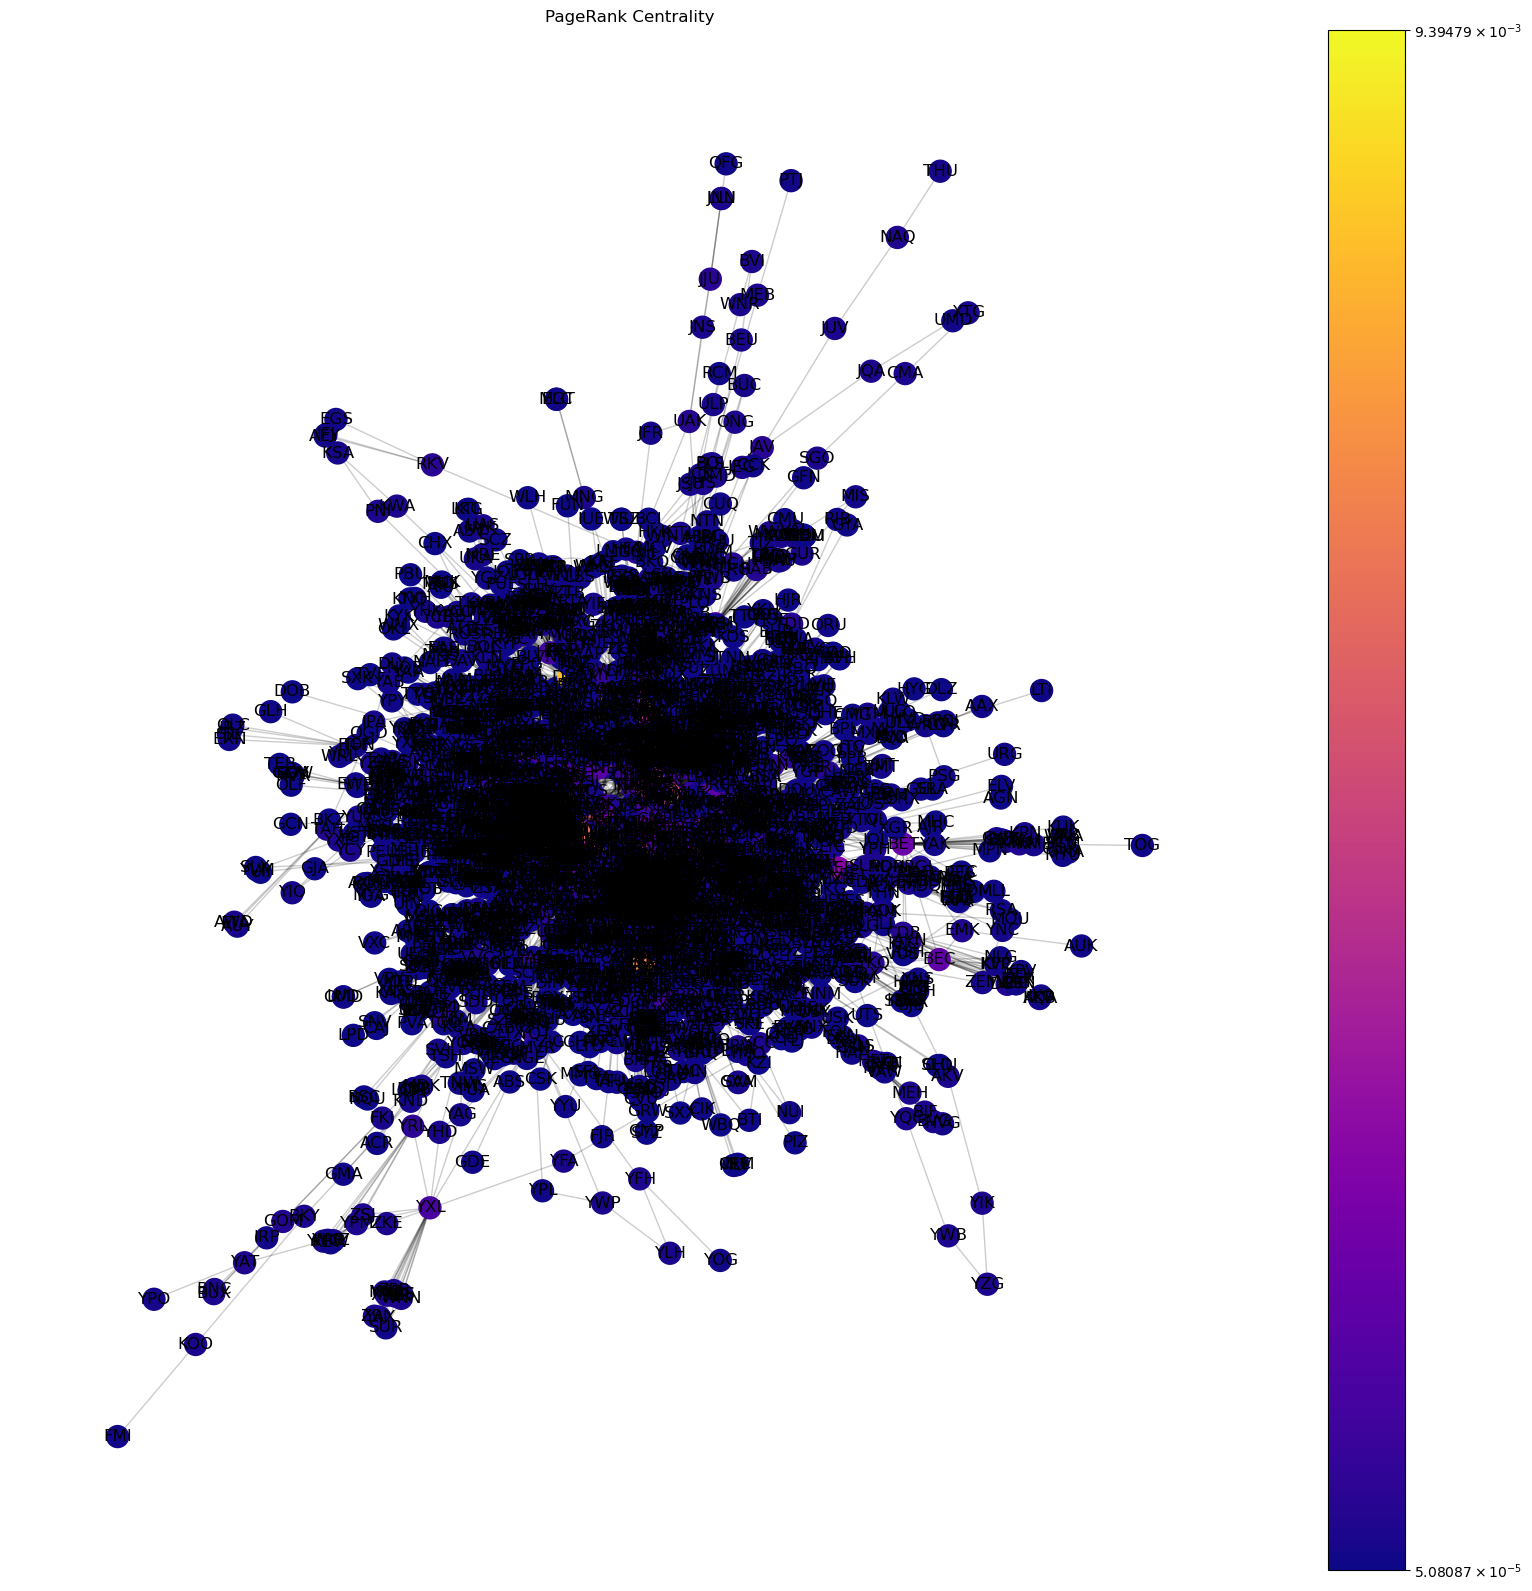

In [45]:
draw_net(comp_1, pos, pagerank, 'PageRank Centrality')

### Newman's Assortativity

In [46]:
nx.degree_assortativity_coefficient(G)

-0.05374178135440394

In [47]:
nx.attribute_assortativity_coefficient(G, 'column of your choice')

C:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:278: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


nan

In [48]:
nx.has_bridges(comp_1)

True

In [49]:
list(nx.bridges(comp_1))

[('POM', 'BUL'),
 ('POM', 'CMU'),
 ('POM', 'MDU'),
 ('POM', 'WBM'),
 ('GOH', 'RKV'),
 ('THU', 'NAQ'),
 ('AEY', 'RKV'),
 ('EGS', 'RKV'),
 ('IFJ', 'RKV'),
 ('YBR', 'YYC'),
 ('YFB', 'YXP'),
 ('YGK', 'YYZ'),
 ('YLL', 'YYC'),
 ('YMO', 'YFA'),
 ('YPR', 'YVR'),
 ('YQL', 'YYC'),
 ('YVM', 'YXP'),
 ('YVP', 'XGR'),
 ('YVR', 'YPW'),
 ('YVR', 'YZT'),
 ('YVR', 'YZZ'),
 ('YVR', 'ZMT'),
 ('YVR', 'YYF'),
 ('YVR', 'YZP'),
 ('YXH', 'YYC'),
 ('YYZ', 'YZR'),
 ('CFK', 'MRS'),
 ('ABV', 'GMO'),
 ('ABV', 'IBA'),
 ('ABV', 'ILR'),
 ('ABV', 'SKO'),
 ('ABV', 'YOL'),
 ('JOS', 'LOS'),
 ('KAD', 'LOS'),
 ('LOS', 'QUO'),
 ('ANR', 'LCY'),
 ('BRU', 'AOE'),
 ('TXL', 'MHG'),
 ('XFW', 'TLS'),
 ('URE', 'TLL'),
 ('TAY', 'HEL'),
 ('HEL', 'JOE'),
 ('HEL', 'KAJ'),
 ('HEL', 'KAO'),
 ('HEL', 'KUO'),
 ('HEL', 'NRK'),
 ('HEL', 'RVN'),
 ('HEL', 'SVL'),
 ('GLO', 'IOM'),
 ('CWL', 'VLY'),
 ('LCY', 'DOL'),
 ('GLA', 'ILY'),
 ('GLA', 'TRE'),
 ('DND', 'STN'),
 ('STN', 'BRQ'),
 ('CPH', 'SGD'),
 ('CPH', 'RNN'),
 ('CPH', 'KRP'),
 ('BOO', 'NVK'

In [50]:
list(nx.local_bridges(comp_1, with_span=True))

[('POM', 'BUL', inf),
 ('POM', 'CMU', inf),
 ('POM', 'MDU', inf),
 ('POM', 'WBM', inf),
 ('GOH', 'KEF', 3),
 ('GOH', 'RKV', inf),
 ('SFJ', 'CPH', 3),
 ('THU', 'NAQ', inf),
 ('AEY', 'RKV', inf),
 ('EGS', 'RKV', inf),
 ('IFJ', 'RKV', inf),
 ('YBR', 'YYC', inf),
 ('YCO', 'YHI', 3),
 ('YCY', 'YFB', 3),
 ('YCY', 'YIO', 3),
 ('YZS', 'YTE', 3),
 ('YDQ', 'YVR', 3),
 ('YDQ', 'YYE', 3),
 ('YFB', 'YOW', 3),
 ('YFB', 'YRT', 3),
 ('YFB', 'YTE', 3),
 ('YFB', 'YXP', inf),
 ('YFB', 'YAB', 3),
 ('YGK', 'YYZ', inf),
 ('YGL', 'YPX', 3),
 ('YHD', 'YQK', 3),
 ('YHU', 'YVO', 3),
 ('YIO', 'YGT', 3),
 ('YLL', 'YYC', inf),
 ('YMM', 'YPY', 3),
 ('YMO', 'YFA', inf),
 ('YMO', 'YTS', 5),
 ('YPR', 'YVR', inf),
 ('YPY', 'YSM', 3),
 ('YQG', 'YTZ', 3),
 ('YQK', 'YAG', 3),
 ('YQK', 'YWG', 3),
 ('YQL', 'YYC', inf),
 ('YQT', 'YFH', 3),
 ('YRB', 'YAB', 3),
 ('YRT', 'YZF', 3),
 ('YUL', 'ZBF', 3),
 ('YUL', 'YMT', 3),
 ('YVM', 'YXP', inf),
 ('YVP', 'XGR', inf),
 ('YVR', 'YPW', inf),
 ('YVR', 'YZT', inf),
 ('YVR', 'YZZ', inf)

In [51]:
def node_overlap(g):
    for u, v in g.edges():
        n_u = set(g.neighbors(u)) # set of u neighbors
        n_v = set(g.neighbors(v)) # set of v neighbors
        overlap = len(n_u & n_v) / len(n_u | n_v) # Neighborhood Overlap
        g[u][v]['overlap'] = overlap
    return g

In [52]:
g = node_overlap(G)

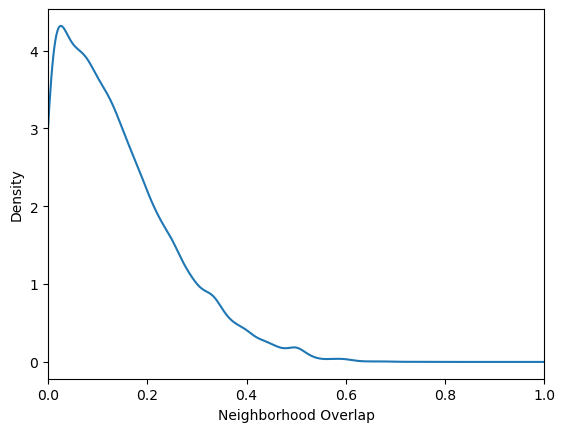

In [53]:
weights = [e[-1]['overlap'] for e in g.edges(data=True)] 
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.xlim(0,1)
plt.show()

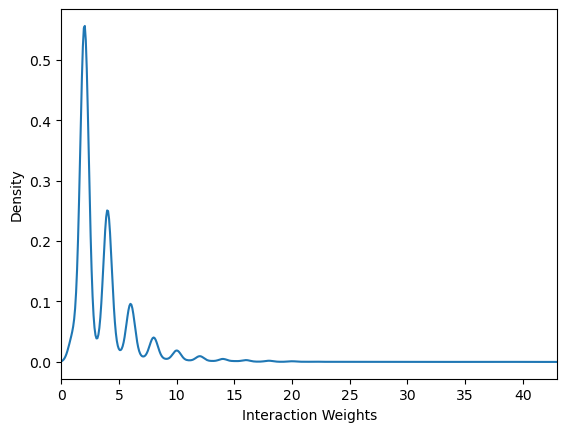

In [54]:
weights_got = [d['weight'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_got)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.xlim(0,max(weights_got))
plt.show()

## 2.7 Erdos-Renyi graph

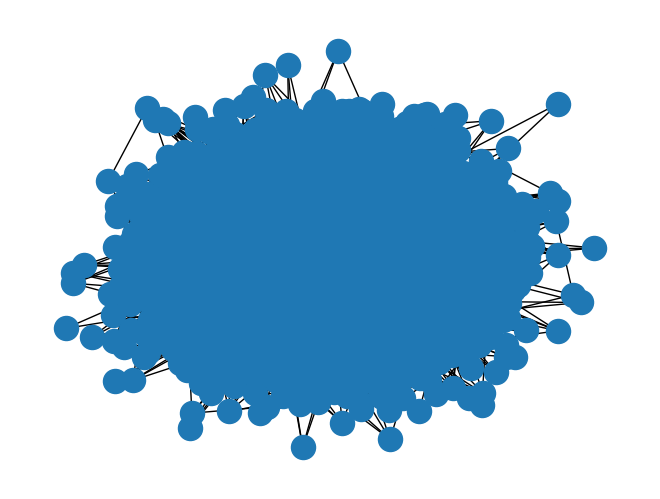

In [55]:
# network generators 1 (random graphs)
er = nx.erdos_renyi_graph(3259, 0.0037)
nx.draw(er)

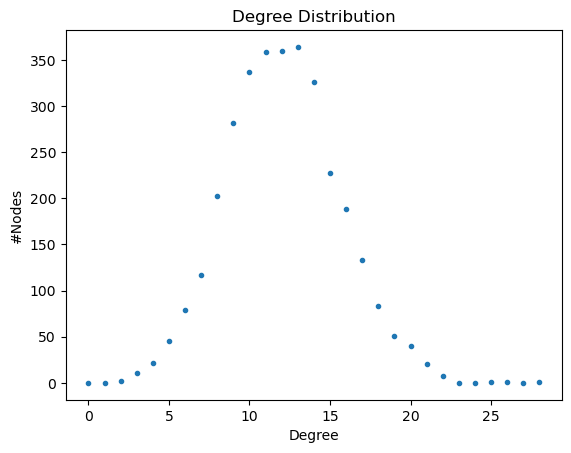

In [56]:
hist = nx.degree_histogram(er)
    
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_22472\3538649401.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array


Calculating best minimal value for power law fit


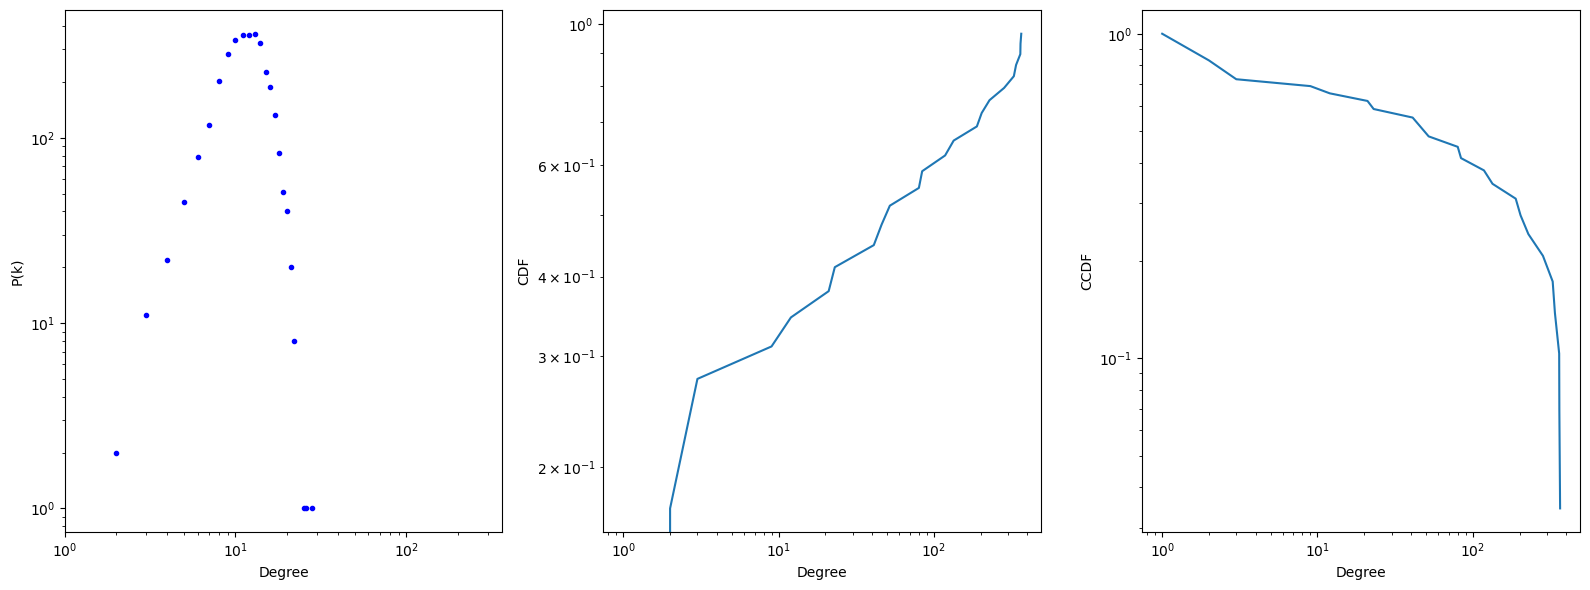

In [57]:
plot_dist(er)

In [88]:
G = er

C:\Users\carlo\AppData\Local\Temp\ipykernel_22472\3538649401.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array


Calculating best minimal value for power law fit


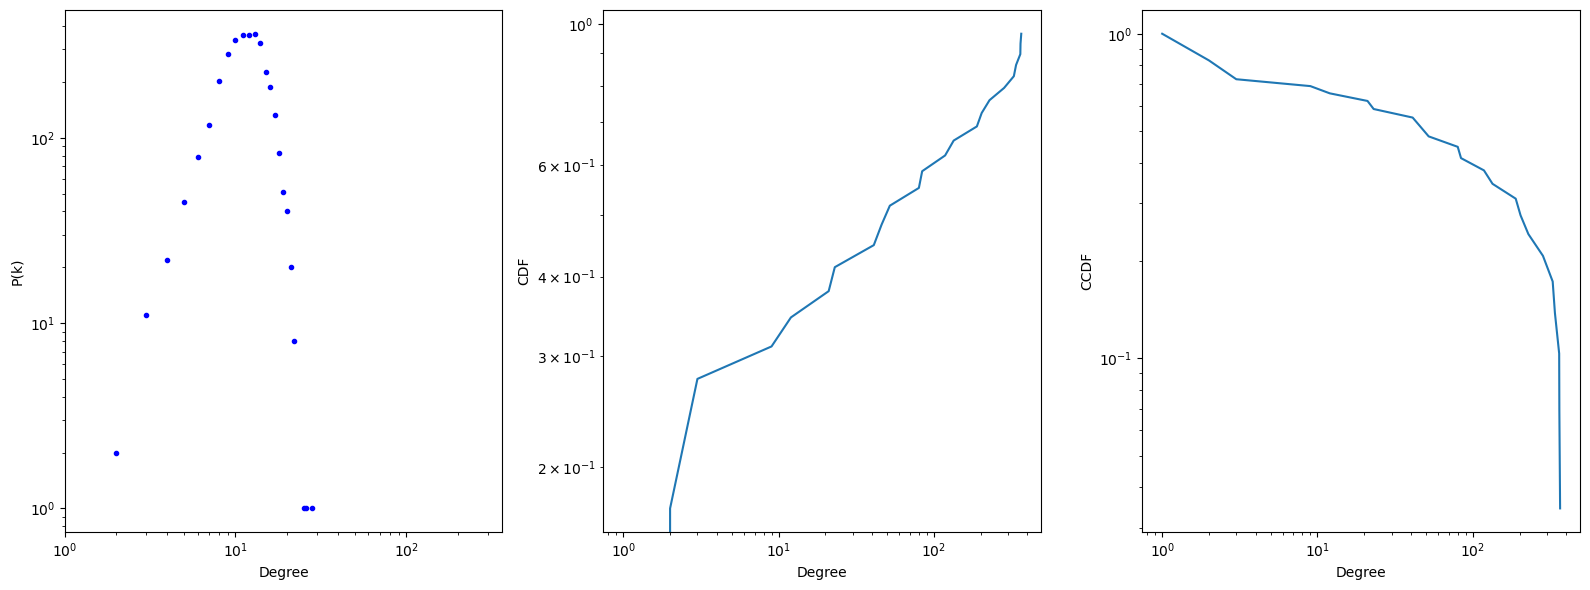

In [59]:
plot_dist(G)

## 2.7.2 Connected components analysis

In [92]:
nx.number_connected_components(G)

1

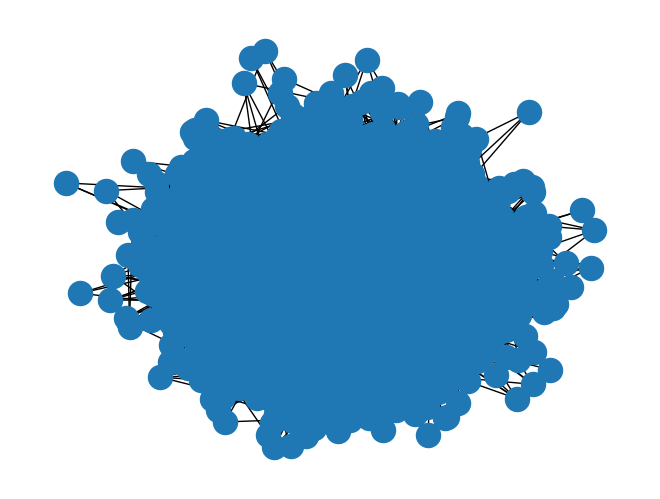

In [93]:
comps = list(nx.connected_components(G)) # get a list of connected components (for decreasing size)
comp_1 = nx.subgraph(G, comps[0]) # build a subgraph on the second component
nx.draw(comp_1)

In [94]:
comp_1.number_of_nodes()

3259

In [95]:
comp_1.number_of_edges()

19672

## 2.7.3 Path Analysis

In [65]:
# Distribuzione delle lunghezze dei percorsi più brevi
path_lengths = dict(nx.shortest_path_length(G))
all_lengths = [dist for lengths in path_lengths.values() for dist in lengths.values()]
print(f"Lunghezza media dei percorsi: {sum(all_lengths) / len(all_lengths):.2f}")
print(f"Lunghezza massima dei percorsi: {max(all_lengths)}")

Lunghezza media dei percorsi: 3.53
Lunghezza massima dei percorsi: 6


In [66]:
# Eccentricità e diametro del grafo
eccentricity = nx.eccentricity(G)
print(f"Eccentricità del grafo: {eccentricity}")
diameter = nx.diameter(G)
print(f"Diametro del grafo: {diameter}")
radius = nx.radius(G)
print(f"Raggio del grafo: {radius}")

Eccentricità del grafo: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5, 16: 5, 17: 5, 18: 5, 19: 5, 20: 5, 21: 5, 22: 5, 23: 5, 24: 5, 25: 5, 26: 5, 27: 5, 28: 5, 29: 5, 30: 5, 31: 5, 32: 4, 33: 5, 34: 5, 35: 5, 36: 5, 37: 5, 38: 5, 39: 5, 40: 5, 41: 5, 42: 5, 43: 5, 44: 5, 45: 5, 46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 4, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 5, 65: 5, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 4, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 5, 101: 5, 102: 5, 103: 5, 104: 4, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 5, 113: 5, 114: 5, 115: 5, 116: 5, 117: 5, 118: 5, 119: 5, 120: 5, 121: 5, 122: 4, 123: 5, 124: 5, 125: 5, 126: 5, 127: 5, 128: 5, 129: 5, 130: 5, 131: 5, 132: 5, 133: 5, 134: 5, 135: 

Diametro del grafo: 6
Raggio del grafo: 4


Il grafo è connesso.


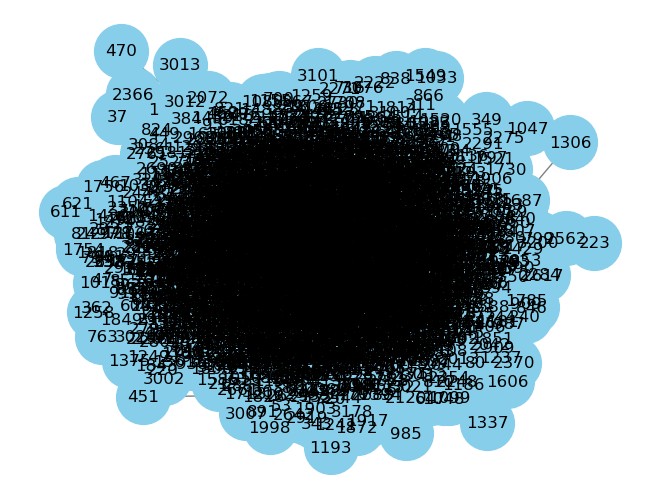

In [67]:
# Connessione tra componenti
if not nx.is_connected(G):
    print("Il grafo non è connesso.")
    components = list(nx.connected_components(G))
    print(f"Numero di componenti connesse: {len(components)}")
    print(f"Dimensione di ogni componente: {[len(c) for c in components]}")
else:
    print("Il grafo è connesso.")

# Visualizzazione del grafo
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500)
plt.show()

## 2.7.4 Clustering Coeffient Analysis

In [68]:
nx.average_clustering(G) # compute the global clustering coefficient

0.0034131591238037167

In [69]:
# Calcolo del clustering coefficient per ogni nodo
local_clustering = nx.clustering(G)
print("Clustering coefficient locale per ogni nodo:")
for node, coeff in local_clustering.items():
    print(f"Nodo {node}: {coeff:.3f}")

Clustering coefficient locale per ogni nodo:
Nodo 0: 0.022
Nodo 1: 0.000
Nodo 2: 0.000
Nodo 3: 0.000
Nodo 4: 0.018
Nodo 5: 0.000
Nodo 6: 0.008
Nodo 7: 0.000
Nodo 8: 0.000
Nodo 9: 0.007
Nodo 10: 0.010
Nodo 11: 0.000
Nodo 12: 0.000
Nodo 13: 0.000
Nodo 14: 0.000
Nodo 15: 0.000
Nodo 16: 0.000
Nodo 17: 0.007
Nodo 18: 0.000
Nodo 19: 0.000
Nodo 20: 0.000
Nodo 21: 0.000
Nodo 22: 0.000
Nodo 23: 0.000
Nodo 24: 0.000
Nodo 25: 0.000
Nodo 26: 0.000
Nodo 27: 0.000
Nodo 28: 0.000
Nodo 29: 0.013
Nodo 30: 0.000
Nodo 31: 0.008
Nodo 32: 0.006
Nodo 33: 0.000
Nodo 34: 0.000
Nodo 35: 0.000
Nodo 36: 0.000
Nodo 37: 0.000
Nodo 38: 0.000
Nodo 39: 0.000
Nodo 40: 0.000
Nodo 41: 0.000
Nodo 42: 0.000
Nodo 43: 0.007
Nodo 44: 0.000
Nodo 45: 0.133
Nodo 46: 0.008
Nodo 47: 0.000
Nodo 48: 0.000
Nodo 49: 0.000
Nodo 50: 0.000
Nodo 51: 0.007
Nodo 52: 0.018
Nodo 53: 0.000
Nodo 54: 0.000
Nodo 55: 0.000
Nodo 56: 0.012
Nodo 57: 0.000
Nodo 58: 0.000
Nodo 59: 0.000
Nodo 60: 0.011
Nodo 61: 0.000
Nodo 62: 0.000
Nodo 63: 0.000
Nodo 

## 2.7.5 Density Analysis

In [70]:
nx.diameter(G.subgraph(comps[0])) # we compute the diameter on the giant component

6

In [71]:
nx.density(G)

0.0037054680328978957

## 2.7.6 Centrality Analysis

In [99]:
degrees = dict(G.degree()) # compute the degree of a set of nodes (if specified).
ranks = [(k, v) for k, v in sorted(degrees.items(), key=lambda item: -item[1])]
ranks[0:5]

[(1755, 28), (1869, 26), (104, 25), (936, 22), (988, 22)]

### Closeness Centrality Measure

In [102]:
closeness = nx.closeness_centrality(G) # compute the closeness centrality of all nodes

ranks = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: -item[1])]
ranks[0:5]



[(1755, 0.31748197232508285),
 (104, 0.3158813263525305),
 (2783, 0.3115914307574598),
 (1869, 0.3103743926836239),
 (2766, 0.3102266235002857)]

### Betweenness Centrality

In [103]:
betweenness = nx.betweenness_centrality(G) # compute the betweenness centraliry of all nodes

ranks = [(k, v) for k, v in sorted(betweenness.items(), key=lambda item: -item[1])]
ranks[0:5]



[(1755, 0.003983374816094015),
 (104, 0.003137018436962129),
 (1869, 0.0030630171979877676),
 (2783, 0.002456034873255429),
 (988, 0.0024276521753672582)]

### Harmonic Centrality

In [104]:
harmonic = nx.harmonic_centrality(G)

ranks = [(k, v) for k, v in sorted(harmonic.items(), key=lambda item: -item[1])]
ranks[0:5]



[(1755, 1086.333333333353),
 (104, 1079.916666666687),
 (2783, 1064.0666666666905),
 (1869, 1062.0000000000227),
 (2766, 1059.41666666669)]

### Pagerank Centrality

In [105]:
pagerank = nx.pagerank(G)

ranks = [(k, v) for k, v in sorted(pagerank.items(), key=lambda item: -item[1])]
ranks[0:5]



[(1755, 0.0006502645107931895),
 (1869, 0.0006068944084968635),
 (104, 0.0005715389311458933),
 (2025, 0.0005219882396438441),
 (2027, 0.0005172816619895992)]

### Newman's Assortativity

In [106]:
nx.degree_assortativity_coefficient(G)

0.016298201747925452

In [107]:
nx.attribute_assortativity_coefficient(G, 'column of your choice')

C:\Users\carlo\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:278: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)


nan

In [110]:
nx.has_bridges(G)

list(nx.bridges(G))

[]

In [ ]:
list(nx.local_bridges(G, with_span=True))

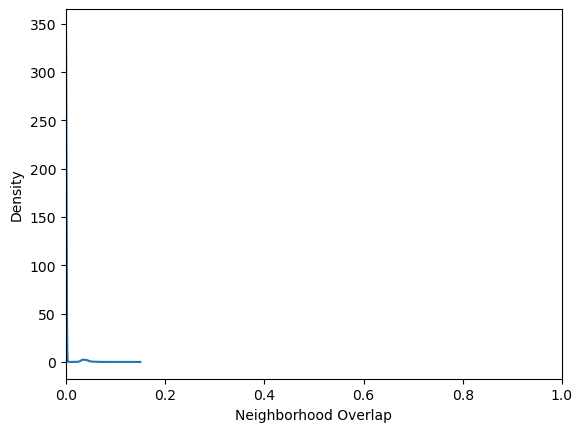

In [113]:
g = node_overlap(G)

weights = [e[-1]['overlap'] for e in g.edges(data=True)] 
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.xlim(0,1)
plt.show()

## 2.8 Barabasi-Albert graph

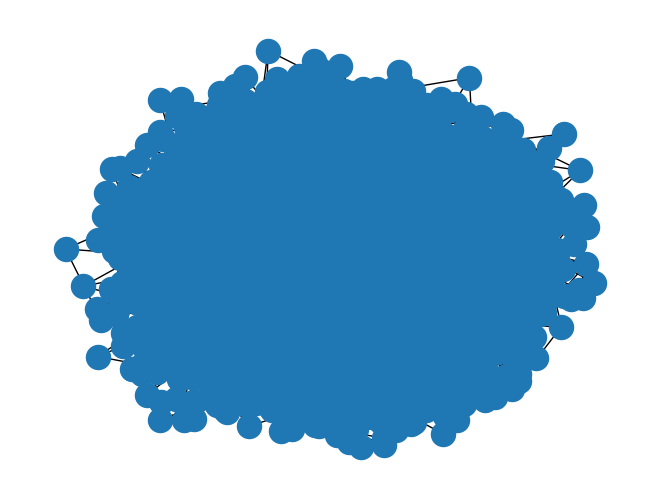

In [116]:
m = 3  # number of links each node establishes once joining the network
ba = nx.barabasi_albert_graph(3259, m)
nx.draw(ba)

C:\Users\carlo\AppData\Local\Temp\ipykernel_22472\3538649401.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array


Calculating best minimal value for power law fit


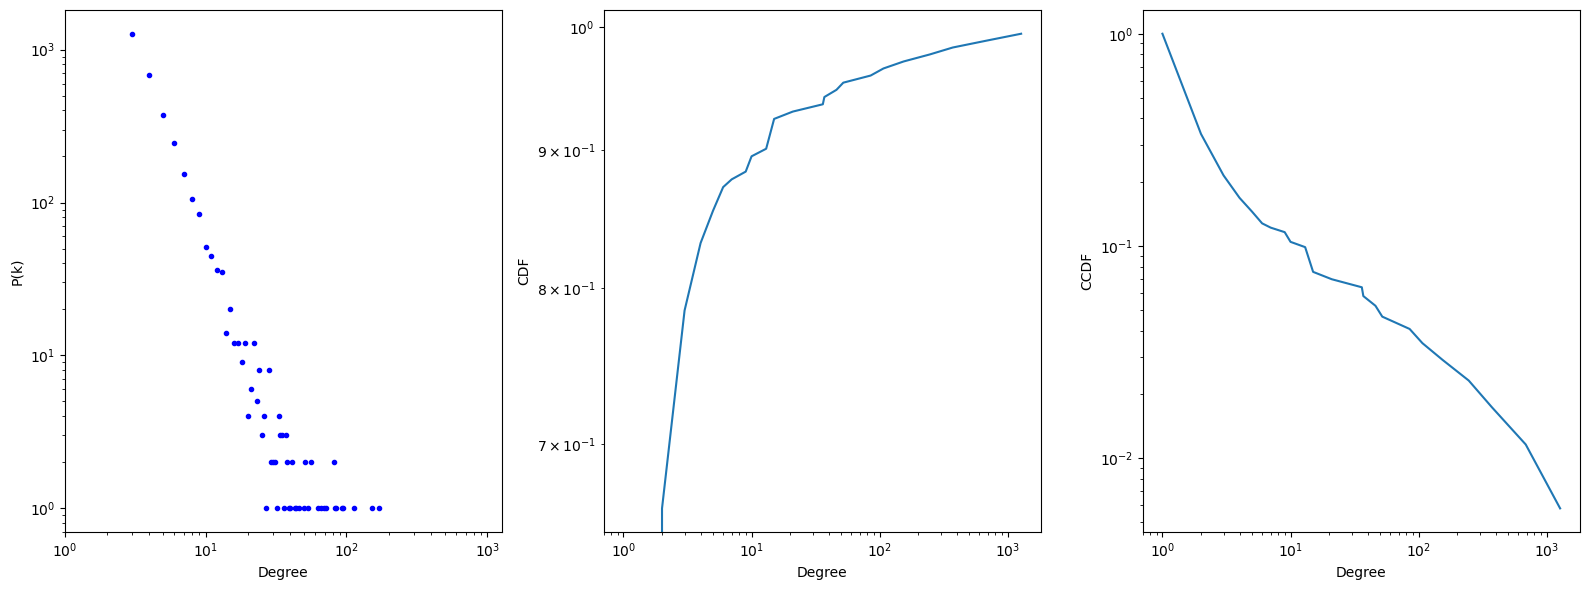

In [117]:
plot_dist(ba)

C:\Users\carlo\AppData\Local\Temp\ipykernel_22472\3538649401.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G).toarray()  # Convert to dense NumPy array


Calculating best minimal value for power law fit


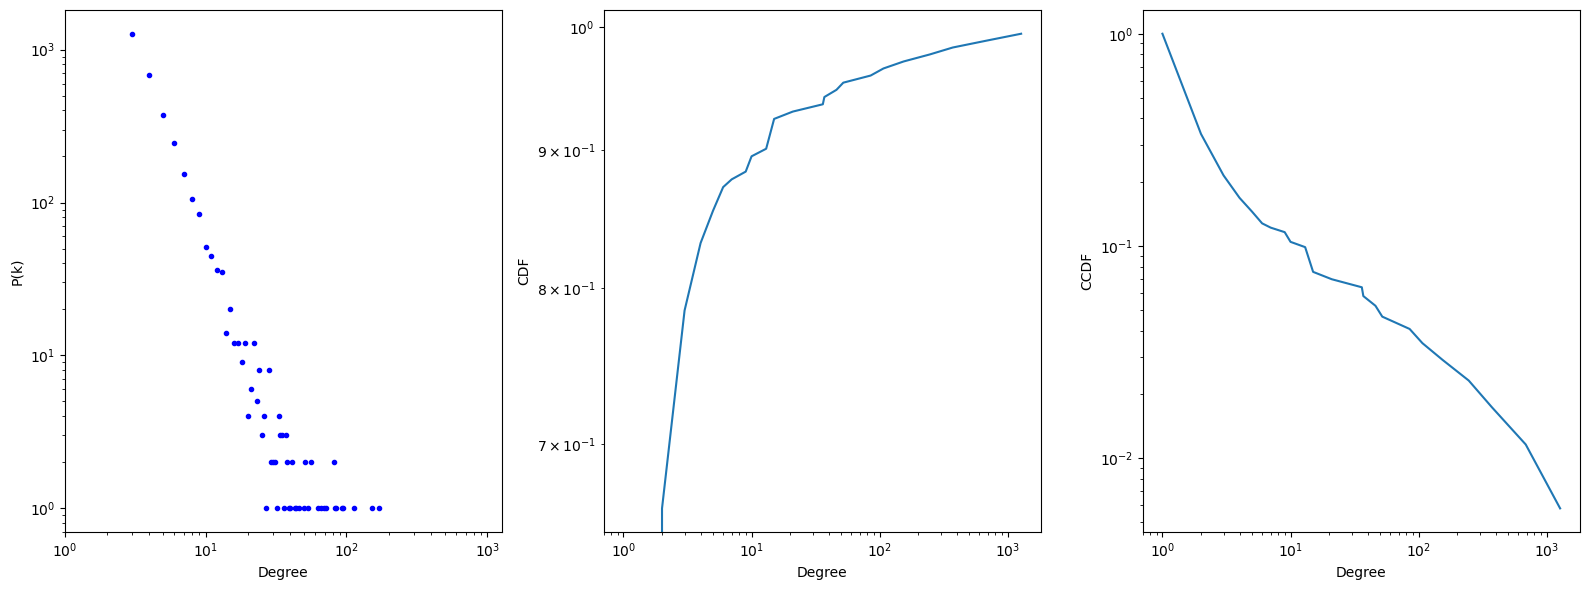

In [118]:
G = ba
plot_dist(G)

## 2.8.2 Connected components analysis

In [119]:
nx.number_connected_components(G)

1

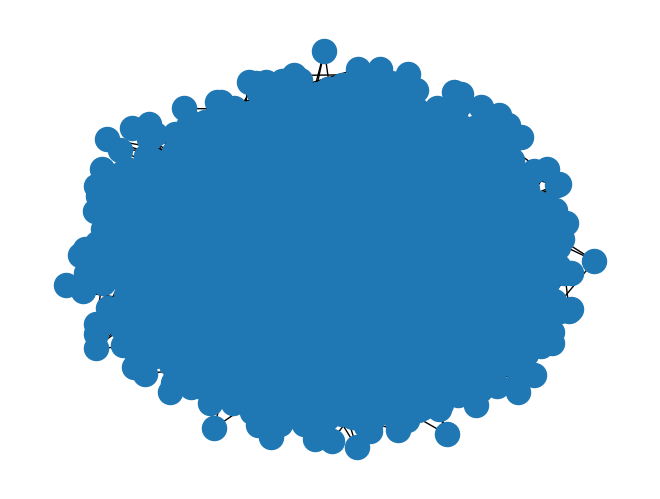

In [120]:
comps = list(nx.connected_components(G)) # get a list of connected components (for decreasing size)
comp_1 = nx.subgraph(G, comps[0]) # build a subgraph on the second component
nx.draw(comp_1)

In [121]:
comp_1.number_of_nodes()

3259

In [122]:
comp_1.number_of_edges()

9768

## 2.8.3 Path Analysis

In [124]:
# Distribuzione delle lunghezze dei percorsi più brevi
path_lengths = dict(nx.shortest_path_length(G))
all_lengths = [dist for lengths in path_lengths.values() for dist in lengths.values()]
print(f"Lunghezza media dei percorsi: {sum(all_lengths) / len(all_lengths):.2f}")
print(f"Lunghezza massima dei percorsi: {max(all_lengths)}")

Lunghezza media dei percorsi: 3.90
Lunghezza massima dei percorsi: 6


In [125]:
# Eccentricità e diametro del grafo
eccentricity = nx.eccentricity(G)
print(f"Eccentricità del grafo: {eccentricity}")
diameter = nx.diameter(G)
print(f"Diametro del grafo: {diameter}")
radius = nx.radius(G)
print(f"Raggio del grafo: {radius}")

Eccentricità del grafo: {0: 4, 1: 4, 2: 5, 3: 5, 4: 4, 5: 4, 6: 4, 7: 5, 8: 5, 9: 4, 10: 4, 11: 4, 12: 4, 13: 4, 14: 5, 15: 4, 16: 4, 17: 5, 18: 5, 19: 5, 20: 5, 21: 4, 22: 5, 23: 5, 24: 5, 25: 5, 26: 5, 27: 4, 28: 5, 29: 5, 30: 5, 31: 4, 32: 4, 33: 5, 34: 5, 35: 5, 36: 5, 37: 5, 38: 5, 39: 5, 40: 5, 41: 5, 42: 5, 43: 5, 44: 5, 45: 5, 46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 5, 56: 5, 57: 5, 58: 5, 59: 5, 60: 5, 61: 5, 62: 5, 63: 5, 64: 5, 65: 5, 66: 5, 67: 5, 68: 5, 69: 5, 70: 5, 71: 5, 72: 5, 73: 5, 74: 5, 75: 5, 76: 5, 77: 5, 78: 5, 79: 5, 80: 5, 81: 5, 82: 5, 83: 5, 84: 5, 85: 5, 86: 5, 87: 5, 88: 5, 89: 5, 90: 5, 91: 5, 92: 5, 93: 5, 94: 5, 95: 5, 96: 5, 97: 5, 98: 5, 99: 5, 100: 5, 101: 5, 102: 5, 103: 5, 104: 5, 105: 5, 106: 5, 107: 5, 108: 5, 109: 5, 110: 5, 111: 5, 112: 5, 113: 5, 114: 5, 115: 5, 116: 5, 117: 5, 118: 5, 119: 5, 120: 5, 121: 5, 122: 5, 123: 5, 124: 5, 125: 5, 126: 5, 127: 5, 128: 5, 129: 5, 130: 5, 131: 5, 132: 5, 133: 5, 134: 5, 135: 

Diametro del grafo: 6
Raggio del grafo: 4


In [126]:
# Connessione tra componenti
if not nx.is_connected(G):
    print("Il grafo non è connesso.")
    components = list(nx.connected_components(G))
    print(f"Numero di componenti connesse: {len(components)}")
    print(f"Dimensione di ogni componente: {[len(c) for c in components]}")
else:
    print("Il grafo è connesso.")

Il grafo è connesso.


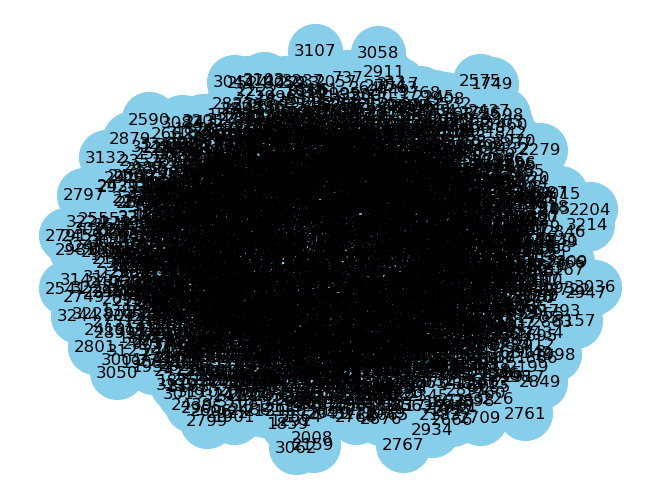

In [127]:
# Visualizzazione del grafo
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500)
plt.show()

## 2.8.4 Clustering Coeffient Analysis

In [128]:
nx.average_clustering(G) # compute the global clustering coefficient

0.012212343897467719

In [129]:
# Calcolo del clustering coefficient per ogni nodo
local_clustering = nx.clustering(G)
print("Clustering coefficient locale per ogni nodo:")
for node, coeff in local_clustering.items():
    print(f"Nodo {node}: {coeff:.3f}")

Clustering coefficient locale per ogni nodo:
Nodo 0: 0.007
Nodo 1: 0.016
Nodo 2: 0.008
Nodo 3: 0.007
Nodo 4: 0.008
Nodo 5: 0.005
Nodo 6: 0.008
Nodo 7: 0.006
Nodo 8: 0.006
Nodo 9: 0.007
Nodo 10: 0.006
Nodo 11: 0.003
Nodo 12: 0.008
Nodo 13: 0.004
Nodo 14: 0.013
Nodo 15: 0.006
Nodo 16: 0.009
Nodo 17: 0.008
Nodo 18: 0.005
Nodo 19: 0.020
Nodo 20: 0.015
Nodo 21: 0.008
Nodo 22: 0.013
Nodo 23: 0.006
Nodo 24: 0.012
Nodo 25: 0.005
Nodo 26: 0.133
Nodo 27: 0.009
Nodo 28: 0.013
Nodo 29: 0.009
Nodo 30: 0.000
Nodo 31: 0.010
Nodo 32: 0.017
Nodo 33: 0.003
Nodo 34: 0.015
Nodo 35: 0.100
Nodo 36: 0.006
Nodo 37: 0.009
Nodo 38: 0.005
Nodo 39: 0.003
Nodo 40: 0.167
Nodo 41: 0.036
Nodo 42: 0.005
Nodo 43: 0.006
Nodo 44: 0.009
Nodo 45: 0.018
Nodo 46: 0.007
Nodo 47: 0.011
Nodo 48: 0.000
Nodo 49: 0.012
Nodo 50: 0.012
Nodo 51: 0.004
Nodo 52: 0.002
Nodo 53: 0.009
Nodo 54: 0.000
Nodo 55: 0.004
Nodo 56: 0.006
Nodo 57: 0.007
Nodo 58: 0.005
Nodo 59: 0.000
Nodo 60: 0.000
Nodo 61: 0.018
Nodo 62: 0.000
Nodo 63: 0.000
Nodo 

## 2.8.5 Density Analysis

In [130]:
nx.diameter(G.subgraph(comps[0])) # we compute the diameter on the giant component

6

In [131]:
nx.density(G)

0.0018399253632242092

## 2.8.6 Centrality Analysis

In [132]:
degrees = dict(comp_1.degree()) # compute the degree of a set of nodes (if specified).

ranks = [(k, v) for k, v in sorted(degrees.items(), key=lambda item: -item[1])]
ranks[0:5]

[(5, 171), (0, 151), (4, 114), (12, 94), (15, 93)]

### Closeness Centrality Measure

In [134]:
closeness = nx.closeness_centrality(comp_1) # compute the closeness centrality of all nodes

ranks = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: -item[1])]
ranks[0:5]



[(5, 0.3953883495145631),
 (0, 0.39514857489387506),
 (4, 0.38199085473091804),
 (12, 0.37010110189708056),
 (15, 0.3604381015599071)]

### Betweenness Centrality

In [135]:
betweenness = nx.betweenness_centrality(comp_1) # compute the betweenness centraliry of all nodes

ranks = [(k, v) for k, v in sorted(betweenness.items(), key=lambda item: -item[1])]
ranks[0:5]



[(5, 0.14049794805556565),
 (0, 0.1276295692167281),
 (4, 0.08445920922940034),
 (12, 0.05786898281258991),
 (15, 0.0488026754695111)]

### Harmonic Centrality

In [137]:
harmonic = nx.harmonic_centrality(G)

ranks = [(k, v) for k, v in sorted(harmonic.items(), key=lambda item: -item[1])]
ranks[0:5]



[(5, 1404.7499999999757),
 (0, 1398.6666666666463),
 (4, 1342.6666666666524),
 (12, 1297.2499999999918),
 (15, 1263.3333333333292)]

### Pagerank Centrality

In [138]:
pagerank = nx.pagerank(G)

ranks = [(k, v) for k, v in sorted(pagerank.items(), key=lambda item: -item[1])]
ranks[0:5]



[(5, 0.0074766652035312305),
 (0, 0.006600127028316131),
 (4, 0.004914379060549291),
 (15, 0.004098083727933068),
 (12, 0.004090971679832804)]

### Newman's Assortativity

In [139]:
nx.degree_assortativity_coefficient(G)

-0.052359734358835466

In [140]:
nx.attribute_assortativity_coefficient(G, 'column of your choice')

nan

In [144]:
nx.has_bridges(G)

False

In [145]:
list(nx.bridges(G))

[]

In [ ]:
list(nx.local_bridges(G, with_span=True))

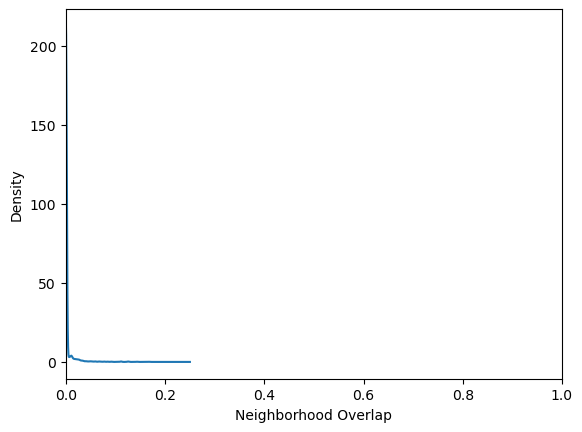

In [147]:
g = node_overlap(G)

weights = [e[-1]['overlap'] for e in g.edges(data=True)] 
pd.DataFrame(weights)[0].plot.kde()
plt.xlabel("Neighborhood Overlap")
plt.xlim(0,1)
plt.show()

In [ ]:
weights_got = [d['weight'] for u,v,d in g.edges(data=True)]
pd.DataFrame(weights_got)[0].plot.kde()
plt.xlabel("Interaction Weights")
plt.xlim(0,max(weights_got))
plt.show()

# Part 4: Open Research Question

In [ ]:
import networkx as nx
from itertools import combinations

def find_all_minimum_vertex_cuts(graph):

    if not nx.is_connected(graph):
        raise ValueError("Il grafo fornito non è connesso.")
    
    min_cut_size = len(nx.minimum_node_cut(graph))
    all_cuts = []
    
    for nodes in combinations(graph.nodes, min_cut_size):
        subgraph = graph.copy()
        subgraph.remove_nodes_from(nodes)
        
        if not nx.is_connected(subgraph):
            all_cuts.append(set(nodes))
    
    return all_cuts

def find_minimum_weight_edge_cut(graph):

    if not nx.is_connected(graph):
        raise ValueError("Il grafo fornito non è connesso.")
    
    source, target = list(graph.nodes)[:2]
    
    cut_value, (reachable, non_reachable) = nx.minimum_cut(
        graph, source, target, capacity="weight"
    )
    
    cut_edges = set()
    for u in reachable:
        for v in graph[u]:
            if v in non_reachable:
                cut_edges.add((u, v) if (u, v) in graph.edges else (v, u))
    
    return cut_value, cut_edges

In [ ]:
find_all_minimum_vertex_cuts(comp_1)

In [ ]:
find_minimum_weight_edge_cut(comp_1)

In [ ]:
def remove_max_edges_while_keeping_connected(graph):

    if not nx.is_connected(graph):
        raise ValueError("Il grafo fornito non è connesso.")
    
    spanning_tree = nx.minimum_spanning_tree(graph)
    
    removed_edges = set(graph.edges) - set(spanning_tree.edges)
    
    return spanning_tree, removed_edges

def maximize_weight_removal_while_keeping_connected(graph):

    if not nx.is_connected(graph):
        raise ValueError("Il grafo fornito non è connesso.")
    
    mst = nx.minimum_spanning_tree(graph, weight='weight')
    
    removed_edges = set(graph.edges) - set(mst.edges)
    
    total_removed_weight = sum(graph[u][v]['weight'] for u, v in removed_edges)
    
    return mst, removed_edges, total_removed_weight

In [ ]:
remove_max_edges_while_keeping_connected(comp_1)

In [ ]:
maximize_weight_removal_while_keeping_connected(comp_1)

In [ ]:
import matplotlib.pyplot as plt

def draw_mst(graph):

    if not nx.is_connected(graph):
        raise ValueError("Il grafo fornito non è connesso.")
    
    mst = nx.minimum_spanning_tree(graph, weight='weight')
    
    pos = nx.spring_layout(graph)
    
    plt.figure(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=nx.get_edge_attributes(graph, 'weight'), font_size=8)
    
    nx.draw(mst, pos, with_labels=True, edge_color='red', width=2, node_size=700, font_size=10)
    
    plt.title("Minimum Spanning Tree (in rosso) sovrapposto al grafo originale")
    plt.show()

In [ ]:
draw_mst(comp_1)